# world-stock-prices-daily-updating

In [ ]:
import os, sys

import kaggle
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

rootpath = os.path.dirname(os.path.dirname(os.getcwd()))

module_path = os.path.abspath(os.path.join(rootpath, 'src'))
sys.path.insert(0, module_path)
from style import plot_params  # in src folder
import vis
import data

print(f'rootpath: {rootpath}')
user = 'nelgiriyewithana'
datasetname = 'world-stock-prices-daily-updating'
datapath = os.path.join(rootpath, 'data')


rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting


## Data Preparation

In [5]:
os.makedirs(datapath, exist_ok=True)
if not os.path.exists(os.path.join(datapath, datasetname)):
    kaggle.api.dataset_download_files(
        dataset=f'{user}/{datasetname}',
        path=datapath,
        unzip=True)
else:
    print('Raw data already found in location {}'.format(datapath))

raw_fpath = os.listdir(os.path.join(datapath, datasetname))[0]
raw_fpath_full = os.path.join(datapath, datasetname, raw_fpath)

print(f'reading raw data from: {raw_fpath_full}')
df_raw = pd.read_csv(raw_fpath_full)
df_raw.head()

Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data
reading raw data from: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv


,Date,Open,High,Low,Close,Volume,Brand_Name,Ticker,Industry_Tag,Country,Dividends,Stock Splits,Capital Gains
0,2025-07-03 00:00:00-04:00,6.630000,6.740000,6.615000,6.640000,4209664.0,peloton,PTON,fitness,usa,0.0,0.0,NaN
1,2025-07-03 00:00:00-04:00,106.750000,108.370003,106.330101,107.339996,560190.0,crocs,CROX,footwear,usa,0.0,0.0,NaN
2,2025-07-03 00:00:00-04:00,122.629997,123.050003,121.550003,121.930000,36600.0,adidas,ADDYY,apparel,germany,0.0,0.0,NaN
3,2025-07-03 00:00:00-04:00,221.705002,224.009995,221.360001,223.410004,29295154.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN
4,2025-07-03 00:00:00-04:00,212.145004,214.649994,211.810104,213.550003,34697317.0,apple,AAPL,technology,usa,0.0,0.0,NaN


In [3]:
df_clean = df_raw.copy()
df_clean['Date'] = pd.to_datetime(df_clean['Date'], utc=True).dt.tz_convert(None)
# df_clean['Date'] = df_clean['Date'].dt.date
df_clean.drop_duplicates(subset=['Date', 'Ticker'], keep='first', inplace=True)
df_clean = df_clean[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']]
df_clean.head()

,Date,Open,High,Low,Close,Volume,Ticker
0,2025-07-03 04:00:00,6.630000,6.740000,6.615000,6.640000,4209664.0,PTON
1,2025-07-03 04:00:00,106.750000,108.370003,106.330101,107.339996,560190.0,CROX
2,2025-07-03 04:00:00,122.629997,123.050003,121.550003,121.930000,36600.0,ADDYY
3,2025-07-03 04:00:00,221.705002,224.009995,221.360001,223.410004,29295154.0,AMZN
4,2025-07-03 04:00:00,212.145004,214.649994,211.810104,213.550003,34697317.0,AAPL


In [5]:
# Load data and compute base features
df = data.extract_ticker(df_clean, 'AAPL', requiredrecords=500, write=False) # datapath=datapath
df['rel_return'] = (df['Close'] - df['Open']) / df['Open']
df['volatility'] = (df['High'] - df['Low']) / ((df['High'] + df['Low']) / 2)
df['dollar_vol'] = df['Volume'] * ((df['Open'] + df['Close']) / 2)
df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
df.head(10)

Extracting for ticker: AAPL
Extracted sample shape: (500, 5)


,Close,rel_return,volatility,dollar_vol
Date,,,,
2025-07-03,213.550003,0.006623,0.013318,7.385237e+09
2025-07-02,212.440002,0.016897,0.024675,1.430344e+10
2025-07-01,207.820007,0.005564,0.019456,1.630465e+10
2025-06-30,205.169998,0.015643,0.039985,1.865143e+10
2025-06-27,201.080002,-0.004037,0.014872,1.421181e+10
2025-06-26,201.000000,-0.002135,0.015817,1.019514e+10
2025-06-25,201.559998,0.000546,0.015088,7.950178e+09
2025-06-24,200.300003,-0.011304,0.016054,1.087249e+10
2025-06-23,201.500000,-0.000645,0.016648,1.120611e+10


## Analysis of Time Series Components for Closing Prices

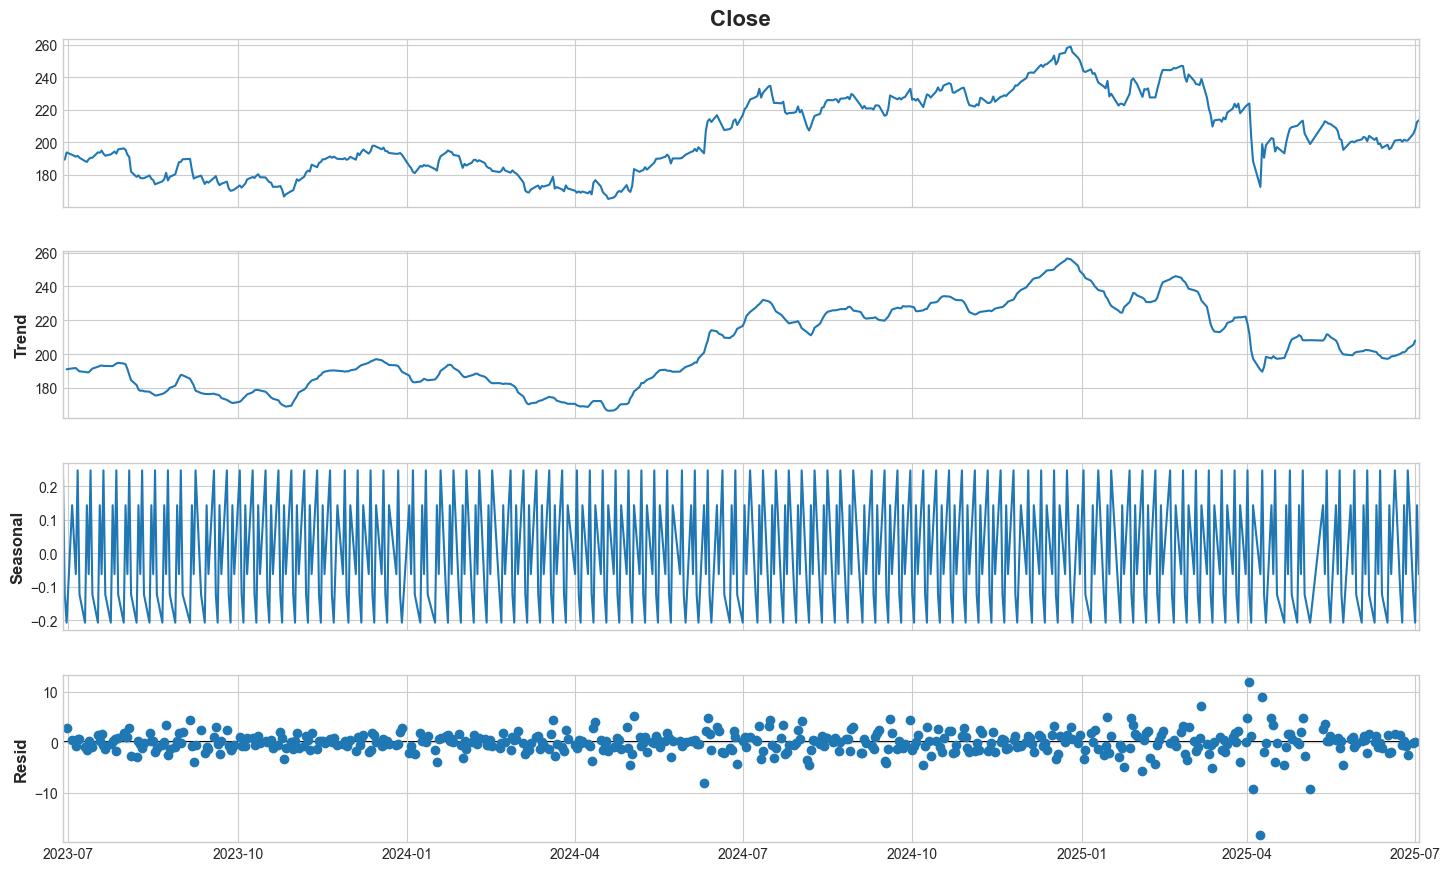

In [6]:
# Seasonal decomposition
vis.plot_seasonal_composition(df, 'Close')

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

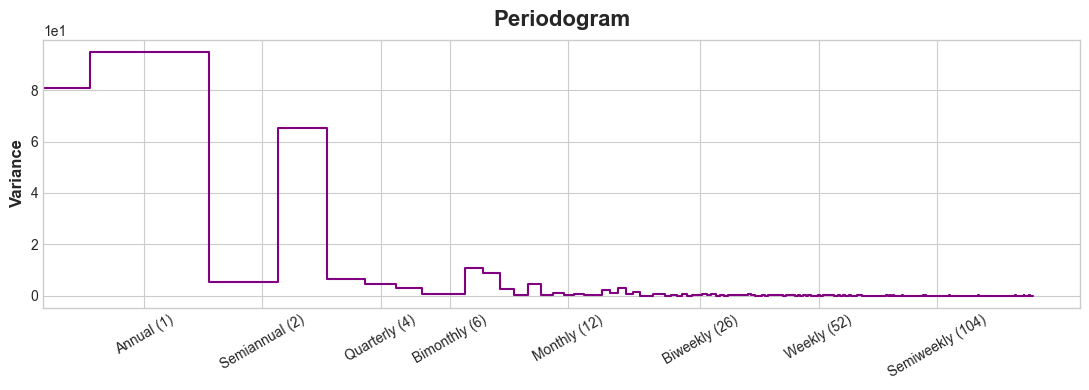

In [7]:
vis.plot_periodogram(df['Close'], detrend='linear')

### Trend

In [8]:
# Fit a trend
y = df['Close'].copy()
dp = DeterministicProcess(
    index = y.index,
    order=3
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X_trend = dp.in_sample()
model = LinearRegression()
model.fit(X_trend, y)

y_pred_trend = pd.Series(model.predict(X_trend), index=X_trend.index)

<Axes: xlabel='Date'>

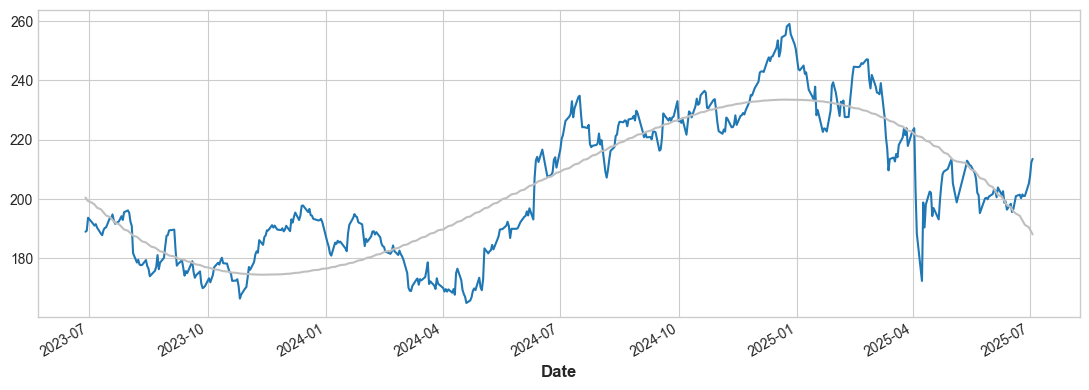

In [9]:
df['Close'].plot()
y_pred_trend.plot(**plot_params, alpha=1.0)

<Axes: xlabel='Date'>

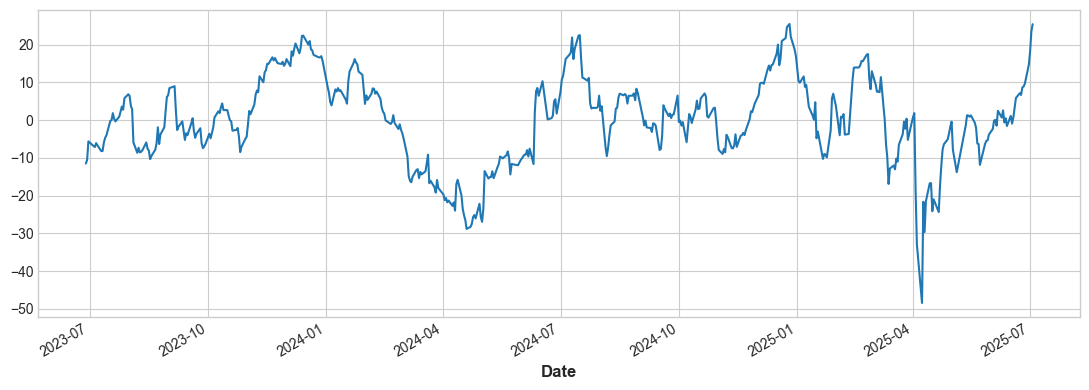

In [10]:
y_detrended = y-y_pred_trend
y_detrended.plot()

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

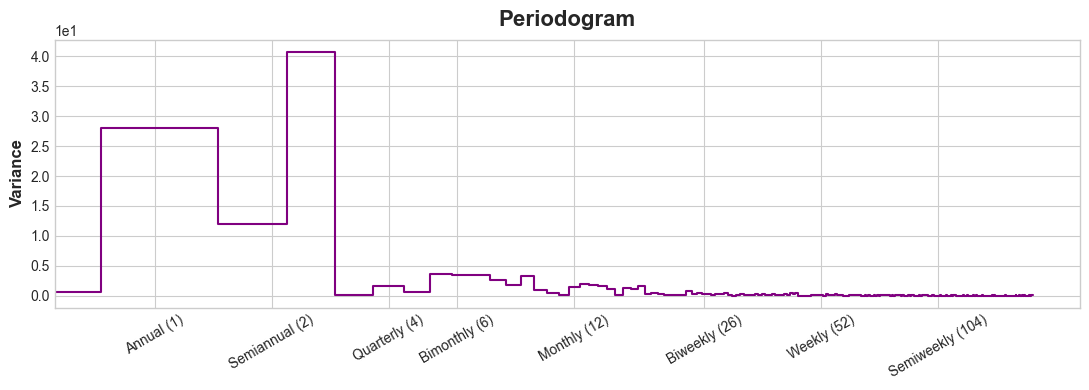

In [11]:
vis.plot_periodogram(y_detrended, detrend='constant')

### Seasonal Components

In [12]:
# Fit a trend and seasonal components
y = df['Close'].copy()

# fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality
# fourier = CalendarFourier(freq="M", order=4)  # 4 sin/cos pairs for "M"onthly seasonality
fourier = [
    CalendarFourier(freq='YE', order=2),  # annual
    # CalendarFourier(freq='QE', order=1),  # quarterly
    CalendarFourier(freq='ME', order=2),  # monthly
    CalendarFourier(freq='W',  order=1),  # weekly
    ]
dp = DeterministicProcess(
    index=y.index,
    constant=False,
    order=3,
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=fourier,    # monthly seasonality (fourier)
    drop=True,
)
X_time = dp.in_sample()

model = LinearRegression()
model.fit(X_time, y)

y_pred_time = pd.Series(model.predict(X_time), index=X_time.index)

<Axes: xlabel='Date'>

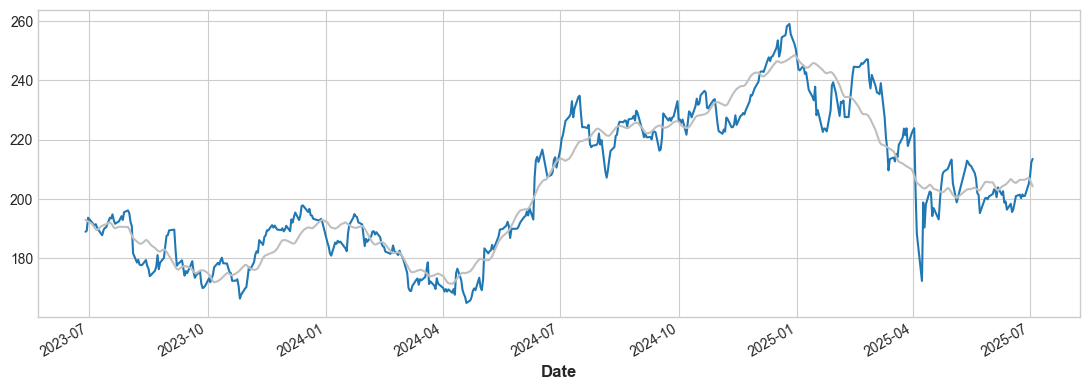

In [13]:
df['Close'].plot()
y_pred_time.plot(**plot_params, alpha=1.0)

<Axes: xlabel='Date'>

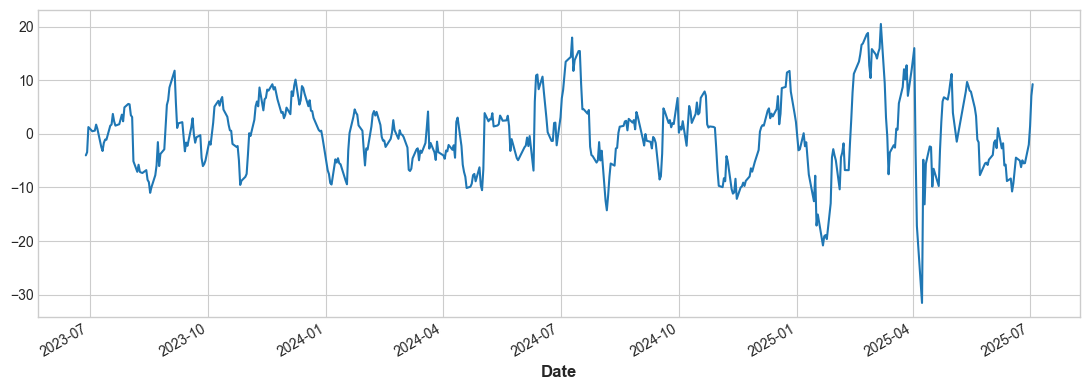

In [14]:
y_detrended_deseasoned = y-y_pred_time
y_detrended_deseasoned.plot()

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

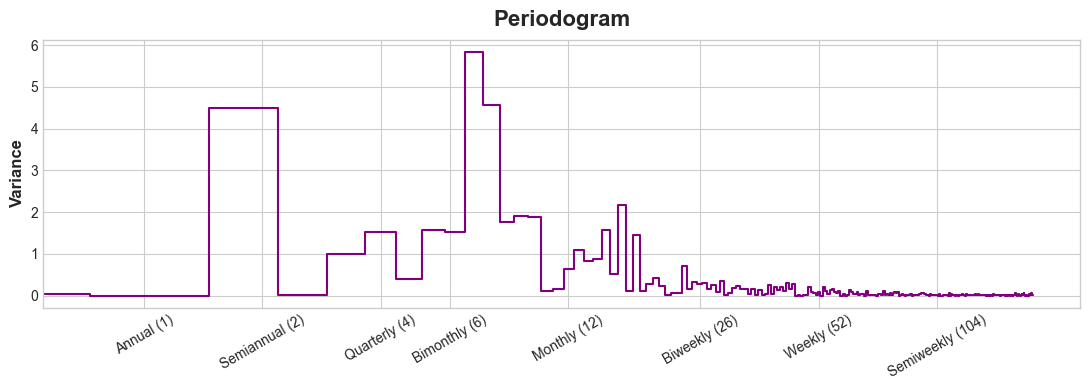

In [15]:
vis.plot_periodogram(y_detrended_deseasoned, detrend='constant')

### Autoregressive Terms

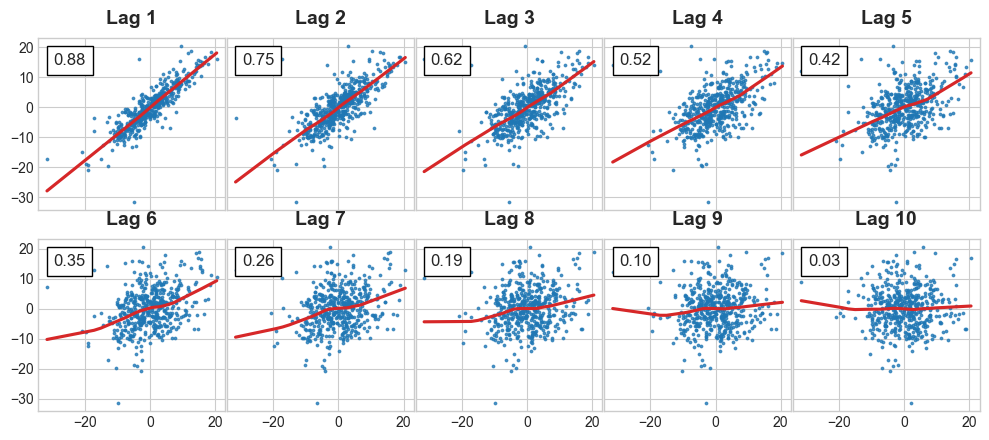

In [16]:
fig = vis.plot_lags(y_detrended_deseasoned, lags=10, nrows=2)

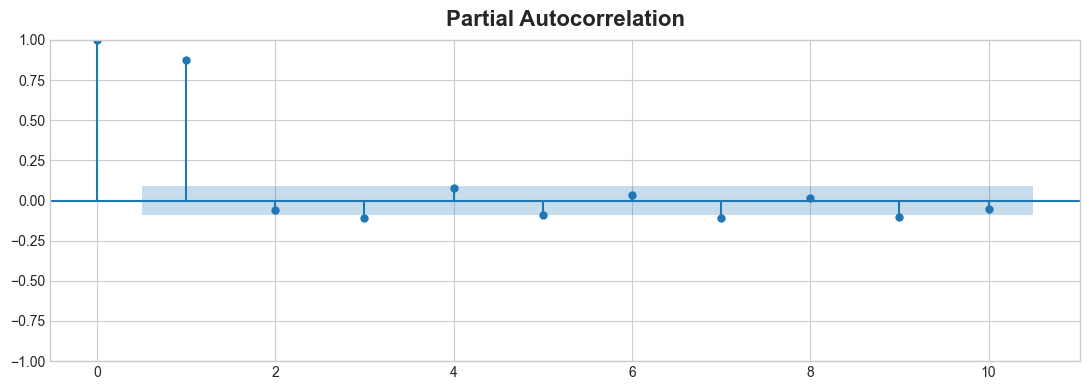

In [17]:
fig = plot_pacf(y_detrended_deseasoned, lags=10)

In [18]:
X_lags = data.make_lags(y_detrended_deseasoned, lags=1)

X_time_lags = pd.concat([X_time, X_lags], axis=1).dropna()
print(f'new X.shape ={X_time_lags.shape}, old y.shape={y.shape}')

y, X_time_lags = y.align(X_time_lags, join='inner')
print(f'new X.shape ={X_time_lags.shape}, new y.shape={y.shape}')

new X.shape =(499, 14), old y.shape=(500,)
new X.shape =(499, 14), new y.shape=(499,)


Training RMSE: 3.31894


<Axes: xlabel='Date'>

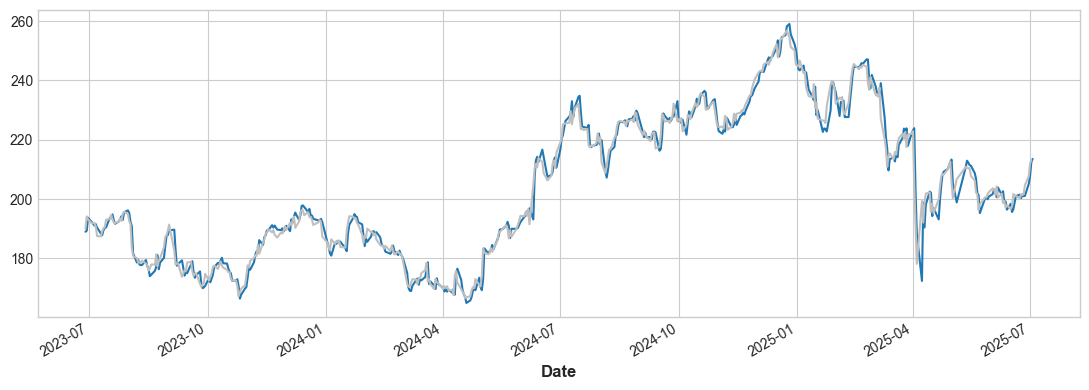

In [19]:
model = LinearRegression()
model.fit(X_time_lags, y)

y_pred_time_lags = pd.Series(model.predict(X_time_lags), index=X_time_lags.index)
rmse = root_mean_squared_error(y, y_pred_time_lags)
print(f'Training RMSE: {rmse:.5f}')

df['Close'].plot()
y_pred_time_lags.plot(**plot_params, alpha=1.0)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

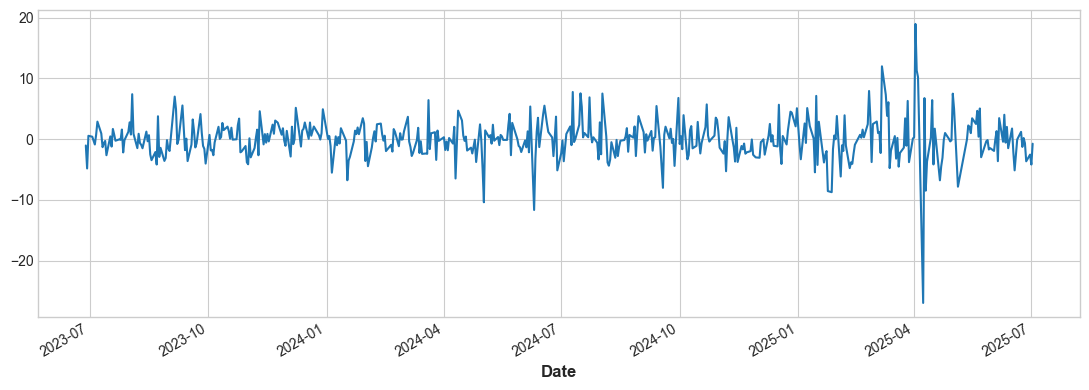

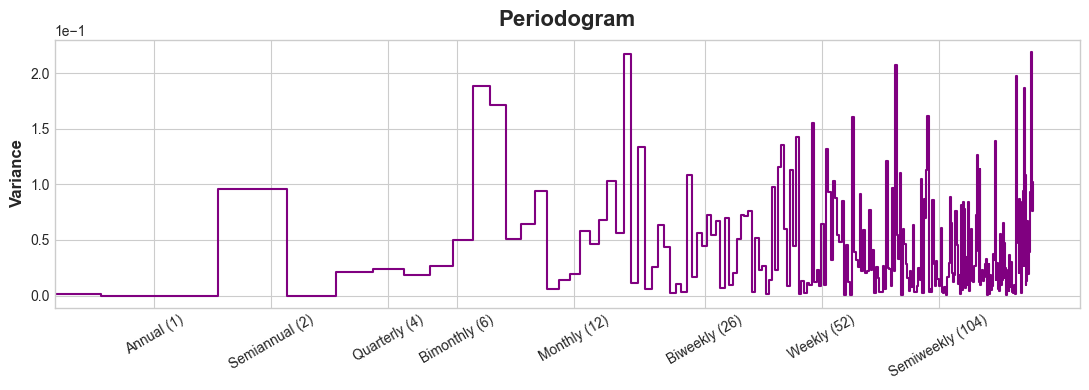

In [20]:
y_resid_time_lags = y - y_pred_time_lags
y_resid_time_lags.plot()
vis.plot_periodogram(y_resid_time_lags, detrend='constant')

### External Factors

In [21]:
X_ext = df[['volatility', 'dollar_vol']]
X_all = pd.concat([X_time, X_ext, X_lags], axis=1).dropna()
print(f'new X.shape ={X_all.shape}, old y.shape={y.shape}')

y, X_all = y.align(X_all, join='inner')
print(f'new X.shape ={X_all.shape}, new y.shape={y.shape}')

new X.shape =(499, 16), old y.shape=(499,)
new X.shape =(499, 16), new y.shape=(499,)


Training RMSE: 3.28291


<Axes: xlabel='Date'>

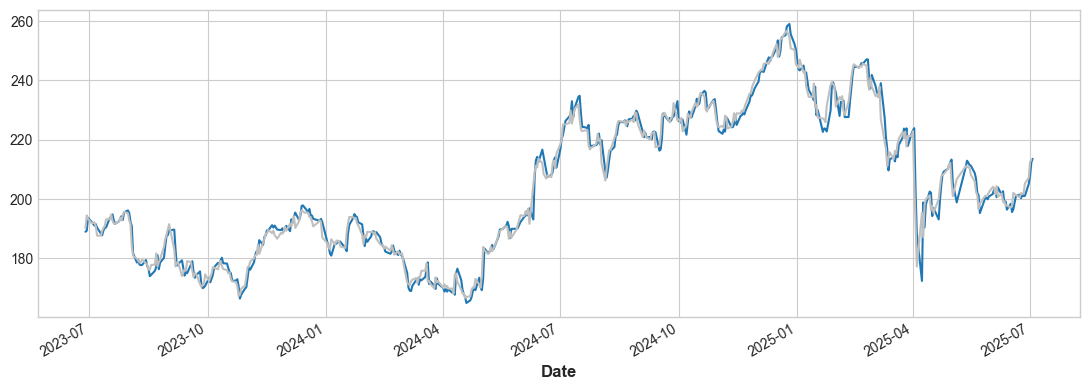

In [22]:
model = LinearRegression()
model.fit(X_all, y)

y_all = pd.Series(model.predict(X_all), index=X_all.index)
rmse = root_mean_squared_error(y, y_all)
print(f'Training RMSE: {rmse:.5f}')

df['Close'].plot()
y_all.plot(**plot_params, alpha=1.0)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

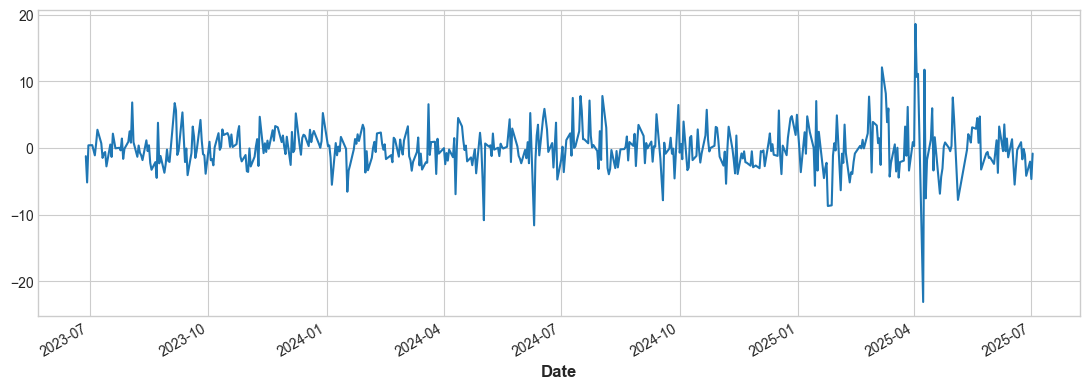

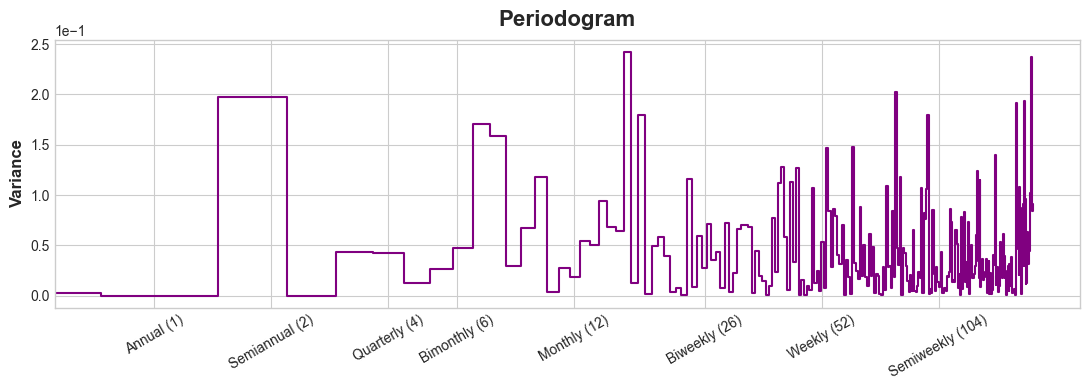

In [23]:
y_resid_all = y - y_all
y_resid_all.plot()
vis.plot_periodogram(y_resid_all, detrend='constant')

## Stacked Forecast Model

In [ ]:
import os

import pandas as pd
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

# local modules
from data import load_raw_data, clean_raw_data, prepare_base_features, split_features_targets, extract_ticker, make_lags
from models import evaluate
import vis

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2

    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)
        # Make predictions with model_1
        y_pred1 = self.model_1.predict(X_1)
        # Compute residuals
        y_resid = y - y_pred1
        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = self.model_1.predict(X_1)
        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)
        # y_pred.unstack(self.stack_cols)
        return y_pred
    
def get_X_time(y, trend_order, seasonal_freqs):
    # time features
    fourier = []
    for freq, order in seasonal_freqs.items():
        print(f'Adding seasonal component: {freq} with order {order}')
        fourier.append(CalendarFourier(freq=freq, order=order))
    dp = DeterministicProcess(
        index=y.index,
        constant=False,
        order=trend_order,
        seasonal=False,               # weekly seasonality (indicators)
        additional_terms=fourier,    # monthly seasonality (fourier)
        drop=True,
    )
    X_time = dp.in_sample()
    return X_time

def get_X_lagsext(df, y, lags, ext_feats):
    # AR features
    X_lags = make_lags(y, lags=lags)
    # External features
    X_ext = df[ext_feats]
    X_all = pd.concat([X_lags, X_ext], axis=1).dropna()
    y, X_all = y.align(X_all, join='inner')
    print(f'new X.shape ={X_all.shape}, new y.shape={y.shape}')
    return X_all, y

def get_X1_X2_y(
        df,
        colstopredict='Close',
        trend_order=3,
        seasonal_freqs={'YE': 2, 'ME': 2, 'W': 1},
        lags=1,
        ext_feats=['volatility', 'dollar_vol']
        ):
    y = df[colstopredict].copy()
    X_1 = get_X_time(y, trend_order, seasonal_freqs)
    print(f'shape X_1:{X_1.shape} y:{y.shape}')
    X_2, y = get_X_lagsext(df, y, lags, ext_feats)
    print(f'shape X_2:{X_2.shape} y:{y.shape}')
    y, X_1 = y.align(X_1, join='inner')
    print (f'(aligned) shape X_1:{X_1.shape} y:{y.shape}')
    return X_1, X_2, y

In [ ]:

df_raw = load_raw_data(
    rootpath=os.path.dirname(os.getcwd()),
    user='nelgiriyewithana',
    datasetname='world-stock-prices-daily-updating')
df_clean = clean_raw_data(df_raw)
ticker = 'AAPL'
df_clean_ticker = extract_ticker(df_clean, ticker, requiredrecords=500, write=False) # datapath=datapat
df = prepare_base_features(df_clean_ticker)
X1, X2, y = get_X1_X2_y(
    df,
    colstopredict='Close',
    trend_order=3,
    seasonal_freqs={'YE': 2, 'ME': 2, 'W': 1},
    lags=1,
    ext_feats=['volatility', 'dollar_vol']
    )
X1_train, X2_train, y_train, X1_test, X2_test, y_test = split_features_targets(X1, X2, y)

rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting
reading raw data from: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv
Extracting for ticker: AAPL
Extracted sample shape: (500, 5)
Adding seasonal component: YE with order 2
Adding seasonal component: ME with order 2
Adding seasonal component: W with order 1
shape X_1:(500, 13) y:(500,)
new X.shape =(499, 3), new y.shape=(499,)
shape X_2:(499, 3) y:(499,)
(aligned) shape X_1:(499, 13) y:(499,)
X1 Train shape: (399, 13), Test shape: (100, 13)
X2 Train shape: (399, 3), Test shape: (100, 3)
y Train shape: (399,), Test shape: (100,)


Training RMSE: 6.89035


<Axes: xlabel='Date'>

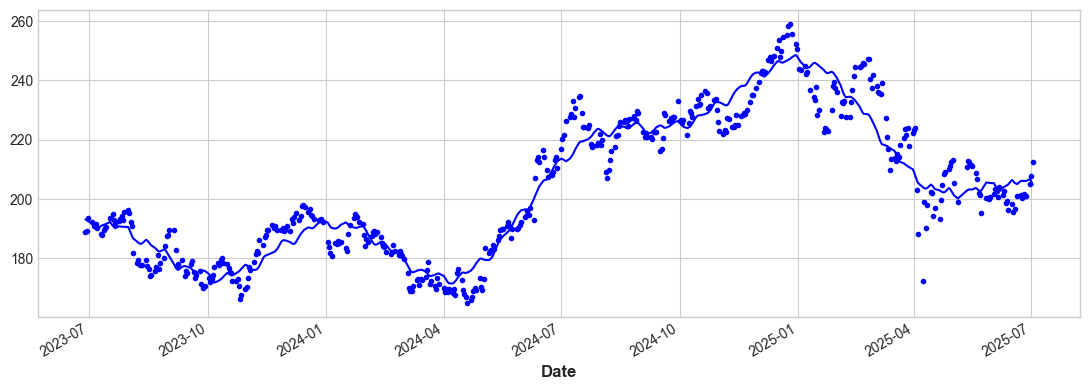

In [27]:
model_1=LinearRegression()
model_1.fit(X1, y)
# Make predictions
y_pred1 = pd.Series(model_1.predict(X1), index=y.index)
# Compute residuals
y_resid1 = y - y_pred1

rmse_train = root_mean_squared_error(y, y_pred1)
print(f'Training RMSE: {rmse_train:.5f}')
y.plot(style=".", color='blue')
y_pred1.plot(style='-', color='blue')


Training RMSE: 6.53306


<Axes: xlabel='Date'>

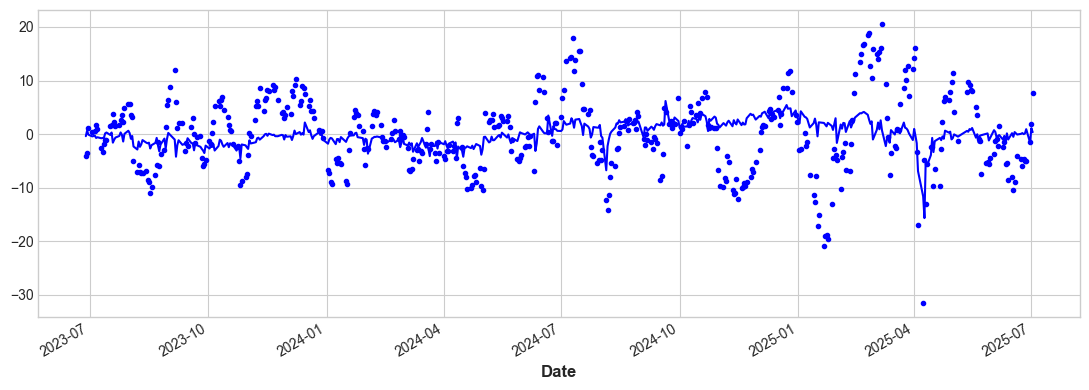

In [28]:
# Train model_2 on residuals
model_2=LinearRegression()
model_2.fit(X2, y_resid1)
y_pred2 = pd.Series(model_2.predict(X2), index=y_resid1.index)

rmse_train = root_mean_squared_error(y_resid1, y_pred2)
print(f'Training RMSE: {rmse_train:.5f}')
y_resid1.plot(style=".", color='blue')
y_pred2.plot(style='-', color='blue')

Training RMSE: 6.53306


<Axes: xlabel='Date'>

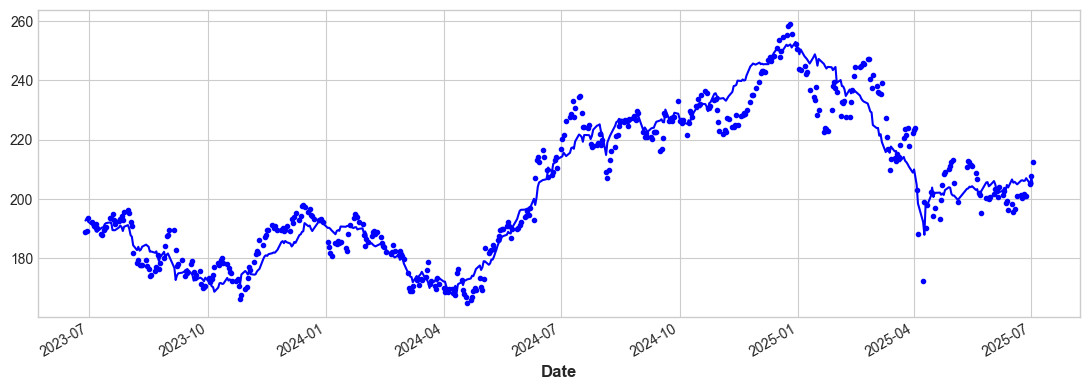

In [29]:
y_pred = y_pred1 + y_pred2

rmse_train = root_mean_squared_error(y, y_pred)
print(f'Training RMSE: {rmse_train:.5f}')
y.plot(style=".", color='blue')
y_pred.plot(style='-', color='blue')


## Stacked Forecast Model with Train-Test split

rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting
reading raw data from: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv
Extracting for ticker: AAPL
Extracted sample shape: (500, 5)
Adding seasonal component: YE with order 2
Adding seasonal component: ME with order 2
Adding seasonal component: W with order 1
shape X_1:(500, 13) y:(500,)
new X.shape =(499, 3), new y.shape=(499,)
shape X_2:(499, 3) y:(499,)
(aligned) shape X_1:(499, 13) y:(499,)
X1 Train shape: (399, 13), Test shape: (100, 13)
X2 Train shape: (399, 3), Test shape: (100, 3)
y Train shape: (399,), Test shape: (100,)
Training RMSE: 5.29275
Test RMSE: 22.42583


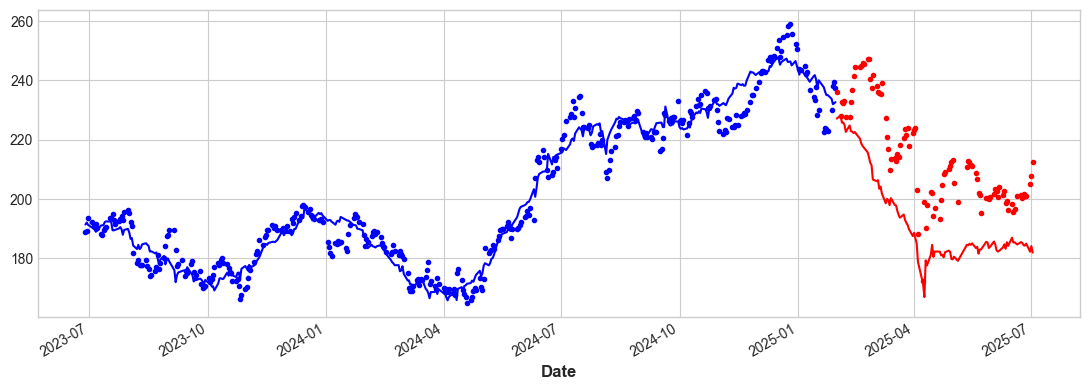

In [ ]:
df_raw = load_raw_data(
    rootpath=os.path.dirname(os.getcwd()),
    user='nelgiriyewithana',
    datasetname='world-stock-prices-daily-updating')
df_clean = clean_raw_data(df_raw)

def ticker_pipeline(df_clean, ticker='AAPL'):
    df_clean_ticker = extract_ticker(df_clean, ticker, requiredrecords=500, write=False) # datapath=datapat
    df = prepare_base_features(df_clean_ticker)
    X1, X2, y = get_X1_X2_y(
        df,
        colstopredict='Close',
        trend_order=3,
        seasonal_freqs={'YE': 2, 'ME': 2, 'W': 1},
        lags=1,
        ext_feats=['volatility', 'dollar_vol']
        )
    X1_train, X2_train, y_train, X1_test, X2_test, y_test = split_features_targets(X1, X2, y)
    model = BoostedHybrid(
        model_1=LinearRegression(),
        model_2=LinearRegression(),
    )
    model.fit(X1_train, X2_train, y_train)
    y_hat_train = pd.Series(model.predict(X1_train, X2_train), index=y_train.index)
    y_hat_test = pd.Series(model.predict(X1_test, X2_test), index=y_test.index)

    evaluate(y_train, y_hat_train, y_test, y_hat_test)
ticker_pipeline(df_clean, ticker='AAPL')

rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting
reading raw data from: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv
Extracting for ticker: AAPL
Extracted sample shape: (500, 5)
Adding seasonal component: YE with order 2
Adding seasonal component: ME with order 2
Adding seasonal component: W with order 1
shape X_1:(500, 10) y:(500,)
new X.shape =(499, 3), new y.shape=(499,)
shape X_2:(499, 3) y:(499,)
(aligned) shape X_1:(499, 10) y:(499,)
X1 Train shape: (399, 10), Test shape: (100, 10)
X2 Train shape: (399, 3), Test shape: (100, 3)
y Train shape: (399,), Test shape: (100,)
Training RMSE: 11.35273
Test RMSE: 24.54392


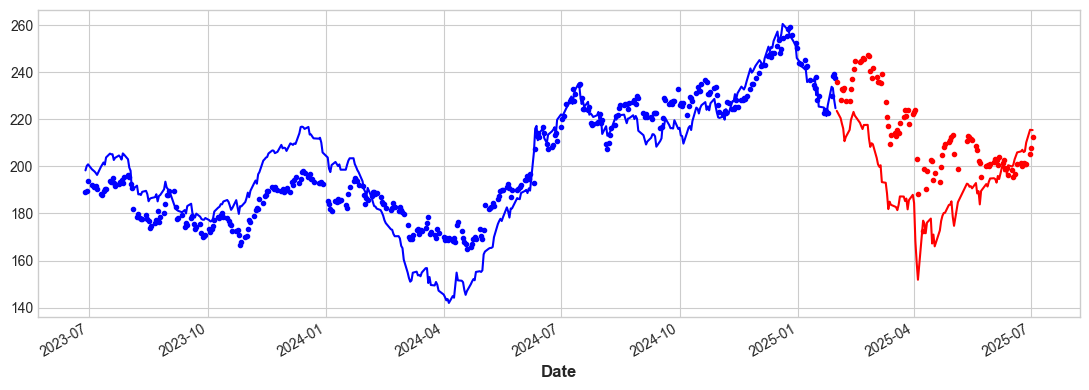

In [ ]:
df_raw = load_raw_data(
    rootpath=os.path.dirname(os.getcwd()),
    user='nelgiriyewithana',
    datasetname='world-stock-prices-daily-updating')
df_clean = clean_raw_data(df_raw)

def ticker_pipeline(df_clean, ticker='AAPL'):
    df_clean_ticker = extract_ticker(df_clean, ticker, requiredrecords=500, write=False) # datapath=datapat
    df = prepare_base_features(df_clean_ticker)
    X1, X2, y = get_X1_X2_y(
        df,
        colstopredict='Close',
        trend_order=0,
        seasonal_freqs={'YE': 2, 'ME': 2, 'W': 1},
        lags=1,
        ext_feats=['volatility', 'dollar_vol']
        )
    X1_train, X2_train, y_train, X1_test, X2_test, y_test = split_features_targets(X1, X2, y)
    model = BoostedHybrid(
        model_1=LinearRegression(),
        model_2=LinearRegression(),
    )
    model.fit(X1_train, X2_train, y_train)
    y_hat_train = pd.Series(model.predict(X1_train, X2_train), index=y_train.index)
    y_hat_test = pd.Series(model.predict(X1_test, X2_test), index=y_test.index)

    evaluate(y_train, y_hat_train, y_test, y_hat_test)
ticker_pipeline(df_clean, ticker='AAPL')